In [ ]:
import numpy as np
import pandas as pd
import scipy.linalg
from sklearn.impute import SimpleImputer
from copy import deepcopy
from threading import Lock # sync
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from scipy.stats import ttest_1samp, linregress
!pip install tabulate

In [ ]:
class MEG:
    def __init__(self, state_size, noise_covar, init_state, init_covar, alpha, k, beta, state_predictor):
        """
        :param state_size: size of the state vector --> the number of return contributing factors
        :param noise_covar: covariance matrix for process noise
        :param init_state: initial state vector
        :param init_covar: initial covariance matrix
        :param alpha: spread of sigma points
        :param k: scaling parameter, often 0 or 3 - state_size
        :param beta: 2 for gaussian distributions
        :param state_predictor: function to predict next state
        :param rho: initial value for the prior coefficient (ρ)
        :param: Sk: an initialization of the S matrix, as updated based on the following formula:
                    for the first time step (k = 0), Sk+1=v1Sk+1​=v1​
                    for subsequent time steps (k ≥ 1), Sk+1=ρSk+vk+1vk+1TSk+1​=ρSk​+vk+1​vk+1T​
        :param lambda_k: initial value for λ:
                    λk=trace(N)/trace(Pzz(k∣k−1))λk​=trace(N)/trace(Pzz​(k∣k−1))
        :param alpha_k: initial time dependent component, adjusts based on λ as follows:
                    αk=λkαk​=λk​ if λk≥1λk​≥1
                    αk=1/λkαk​=1/λk​ if λk<1λk​<1
        """
        self.state_dim = state_size
        self.sigma_count = 2 * state_size + 1
        self.noise_covar = noise_covar
        self.state = init_state
        self.covar = init_covar
        self.beta = beta
        self.alpha = alpha
        self.k = k
        self.predict_next_state = state_predictor
        self.rho = 1.0 # initial value for the prior coefficient
        self.Sk = np.zeros((state_size, state_size)) # initialize S matrix
        self.lambda_k = 1.0 # initial value for lambda
        self.alpha_k = 1.0 # initial alpha

        # scaling factor for sigma points
        self.lambda_ = alpha**2 * (state_size + k) - state_size

        # weights for mean and covariance
        self.mean_weights = np.zeros(self.sigma_count)
        self.cov_weights = np.zeros(self.sigma_count)
        self.mean_weights[0] = self.lambda_ / (state_size + self.lambda_)
        self.cov_weights[0] = self.mean_weights[0] + (1 - alpha**2 + beta)
        for i in range(1, self.sigma_count):
            self.mean_weights[i] = self.cov_weights[i] = 1 / (2 * (state_size + self.lambda_))

        self.sigma_points = self.calc_sigmas()

    def calc_alpha_k(self, Pzz, vk):
        """
        calculates the time dependent component alpha_k
        :param Pzz: predicted innovation covariance matrix
        :param vk: prediction residual error
        :return: updated alpha_k value
        """
        self.Sk = self.rho * self.Sk + np.outer(vk, vk) / (1 + self.rho)
        self.lambda_k = np.trace(self.Sk) / np.trace(Pzz)
        self.alpha_k = max(1, self.lambda_k)
        return self.alpha_k

    def calc_sigmas(self):
        # calculate square root of scaled covariance matrix
        scaled_covar = (self.state_dim + self.lambda_) * self.covar
        U = scipy.linalg.cholesky(scaled_covar, lower=True)

        # initialize sigma points array
        sigmas = np.zeros((self.sigma_count, self.state_dim))

        # set the first sigma point to the mean state
        sigmas[0] = self.state

        # the remaining sigma points
        for k in range(self.state_dim):
            sqrt_col = U[:, k]
            sigmas[k + 1] = self.state + sqrt_col
            sigmas[self.state_dim + k + 1] = self.state - sqrt_col

        return sigmas

    def predict(self, delta_time, timestep):
        # predicted sigma points, passing the current timestep
        sigmas_out = np.array([self.state_predictor(x, timestep) for x in self.sigma_points])

        # predicted state mean
        self.state = np.dot(self.mean_weights, sigmas_out)

        #  predicted state covariance
        self.covar = np.zeros((self.state_dim, self.state_dim))
        for i in range(self.sigma_count):
            diff = sigmas_out[i] - self.state
            self.covar += self.cov_weights[i] * np.outer(diff, diff)
        self.covar += self.noise_covar

        # recalculate sigma points based on new state and covariance
        self.sigma_points = self.calc_sigmas()

    def update(self, asset_indices, market_data, error_covar):
        """
        new data into the filter
        :param asset_indices: indices of the assets being updated
        :param market_data: corresponding new data for the assets
        :param error_covar: covariance matrix for measurement errors
        """
        # sigma points into measurement space
        sigmas_meas = np.array([self.state_to_measurement(x) for x in self.sigma_points])

        # predicted measurement mean
        predicted_meas = np.dot(self.mean_weights, sigmas_meas)

        # predicted measurement covariance
        Pyy = np.zeros((len(asset_indices), len(asset_indices)))
        Pxy = np.zeros((self.state_dim, len(asset_indices)))
        for i in range(self.sigma_count):
            diff_meas = sigmas_meas[i] - predicted_meas
            diff_state = self.sigma_points[i] - self.state
            Pyy += self.cov_weights[i] * np.outer(diff_meas, diff_meas)
            Pxy += self.cov_weights[i] * np.outer(diff_state, diff_meas)
        Pyy += error_covar

        # kalman gain
        K = np.dot(Pxy, np.linalg.inv(Pyy))

        # update state and covariance with measurement
        self.state += np.dot(K, (market_data - predicted_meas))
        self.covar -= np.dot(K, np.dot(Pyy, K.T))

    def state_to_measurement(self, state):
        # state to measurement space
        return state

    def get_state(self, index=-1):
        """
        retrieves the current state or a specific state variable
        :param index: index of the state variable, -1 for full state
        :return: state variable or full state
        """
        return self.state[index] if index >= 0 else self.state

    def get_covar(self):
        """ the current state covariance matrix """
        return self.covar

    def override_state(self, value, index=-1):
        """
        overrides the filter state
        :param value: new value for the state variable or full state
        :param index: index of the state variable, -1 for full state
        """
        with self.lock:
            if index != -1:
                self.state[index] = value
            else:
                self.state = value

    def restart(self, state, covar):
        """
        restarts the filter with a new state and covariance
        :param state: new state vector
        :param covar: new covariance matrix
        """
        with self.lock:
            self.state = state
            self.covar = covar
    def state_predictor(self, state, timestep):
        """
        predicts the next state considering the factors.
        - the baseline is a set of long-term means for each factor, calculated as rolling averages from historical data.
        - momentum_weight and mean_reversion_weight are functions of time.
        """
        # define the long-term mean (baseline) for the factors
        baseline = [long_term_mean_r_mkt.iloc[timestep], long_term_mean_r_me.iloc[timestep],
                    long_term_mean_r_ia.iloc[timestep], long_term_mean_r_roe.iloc[timestep],
                    long_term_mean_r_eg.iloc[timestep]]

        # weight factors for momentum
        momentum_weight = momentum_weight_function(timestep)

        # weight factors for mean-reversion
        mean_reversion_weight = mean_reversion_weight_function(timestep)

        # calculate the next state as a combination of the current state, baseline, and weights
        next_state = []
        for i, current_state in enumerate(state):
            adjusted_state = (1 - momentum_weight - mean_reversion_weight) * current_state + \
                            momentum_weight * baseline[i] + \
                            mean_reversion_weight * baseline[i]
            next_state.append(adjusted_state)

        return np.array(next_state)

In [ ]:
from google.colab import files

In [ ]:
uploaded = files.upload()

Saving q5_factors_daily_2022.xlsx to q5_factors_daily_2022.xlsx


In [ ]:
file = list(uploaded.keys())[0]
df = pd.read_excel(file)
print(df.head()) # R_F: Risk-free rate of return; R_MKT: market premium; R_ME: market equity;
# R_IA: investment factor; R_ROE: equity factor; R_EG: Earnings growth factor.

       DATE     R_F   R_MKT    R_ME    R_IA   R_ROE    R_EG
0  19670103  0.0187  0.0778  0.4944  0.1437 -0.7118 -0.8563
1  19670104  0.0187  0.1667 -0.3487 -0.0631 -0.2044 -0.0295
2  19670105  0.0187  1.2990  0.4412 -0.5688  0.0838 -0.3075
3  19670106  0.0187  0.7230  0.6669  0.8897  0.3603  0.2669
4  19670109  0.0187  0.8439  0.6315  0.0331  0.4949  0.2979


In [ ]:
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d')
for col in df.columns[1:]:  # skip the DATE column
    df[col] = pd.to_numeric(df[col], errors='coerce')

# mean imputation
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df[df.columns[1:]] = imputer.fit_transform(df[df.columns[1:]])

print(df.head())

        DATE     R_F   R_MKT    R_ME    R_IA   R_ROE    R_EG
0 1967-01-03  0.0187  0.0778  0.4944  0.1437 -0.7118 -0.8563
1 1967-01-04  0.0187  0.1667 -0.3487 -0.0631 -0.2044 -0.0295
2 1967-01-05  0.0187  1.2990  0.4412 -0.5688  0.0838 -0.3075
3 1967-01-06  0.0187  0.7230  0.6669  0.8897  0.3603  0.2669
4 1967-01-09  0.0187  0.8439  0.6315  0.0331  0.4949  0.2979


In [ ]:
# parameters initialization
state_size = 5  # number of factors
noise_covar = np.eye(state_size) * 0.05
init_state = np.array([0.0778, 0.4944, 0.1437, -0.7118, -0.8563])
init_covar = np.eye(state_size) * 0.75
alpha, k, beta = 1e-2, 0, 2

# long term means:
"""
calculate the long-term means for each factor based on historical data
they serve as baselines for the factors in the state predictor
"""
rolling_window = 7 * 252 # assume 252 days per year and one crisis per 7 years

long_term_mean_r_mkt = df['R_MKT'].rolling(window=rolling_window, min_periods=1).mean()
long_term_mean_r_me = df['R_ME'].rolling(window=rolling_window, min_periods=1).mean()
long_term_mean_r_ia = df['R_IA'].rolling(window=rolling_window, min_periods=1).mean()
long_term_mean_r_roe = df['R_ROE'].rolling(window=rolling_window, min_periods=1).mean()
long_term_mean_r_eg = df['R_EG'].rolling(window=rolling_window, min_periods=1).mean()

def momentum_weight_function(timestep):
    # momentum duration and peak
    peak = 6  # months
    duration = 12  # months
    timestep_in_months = timestep / 30
    # calculate the momentum weight
    if timestep_in_months <= duration:
        return np.sin(np.pi * timestep_in_months / duration)  # sinusoidal weight
    else:
        return 0  # no momentum after the duration

def mean_reversion_weight_function(timestep):
    # define mean-reversion cycle (customize these values)
    cycle = 60  # months for a 5-year cycle
    # convert timestep to months if necessary
    timestep_in_months = timestep / 30  # assuming timestep is in days
    # the mean-reversion weight (customize the formula as needed)
    return (timestep_in_months % cycle) / cycle  # linearly increasing weight

# initialize MEG
marg = MEG(state_size, noise_covar, init_state, init_covar, alpha, k, beta, MEG.state_predictor)

In [ ]:
num_timesteps = 12000  # number of timesteps to simulate
simulated_states = [init_state]  # store the initial state

for timestep in range(1, num_timesteps):
    # predict the next state using the state_predictor function of the MEG class
    next_state = marg.state_predictor(simulated_states[-1], timestep)
    simulated_states.append(next_state)
print("final simulated state:", simulated_states[-1])

states_array = np.array(simulated_states)
means = np.mean(states_array, axis=0)
std_devs = np.std(states_array, axis=0)
print("mean of state variables over time:", means)
print("standard deviation of state variables over time:", std_devs)

final simulated state: [0.03727582 0.01154667 0.00888694 0.00435468 0.01379091]
mean of state variables over time: [0.02487687 0.01771437 0.01988623 0.02947881 0.04018444]
standard deviation of state variables over time: [0.0296894  0.03433084 0.01525154 0.02445418 0.03120352]


In [ ]:
from tabulate import tabulate
num_variables = states_array.shape[1]  # number of state variables
timesteps = np.arange(states_array.shape[0])

# initialize results dataframe
results_df = pd.DataFrame(columns=['Final Simulated State', 'Mean', 'Std Dev',
                                   'ADF P-Value', 'T-Test P-Value', 'Std Dev Slope', 'Std Dev Slope P-Value'])

for i in range(num_variables):
    # final Simulated State
    final_simulated_state = states_array[-1, i]

    # mean and std dev
    mean = np.mean(states_array[:, i])
    std_dev = np.std(states_array[:, i])

    # adf
    adf_p_value = adfuller(states_array[:, i])[1]

    # one-Sample t-test
    t_test_p_value = ttest_1samp(states_array[:, i], init_state[i])[1]

    # linear regression on std dev over time
    std_devs_over_time = [np.std(states_array[:t+1, i]) for t in timesteps]
    slope, intercept, r_value, slope_p_value, std_err = linregress(timesteps, std_devs_over_time)
    results_df.loc[f'state_variable_{i}'] = [final_simulated_state, mean, std_dev,
                                             adf_p_value, t_test_p_value, slope, slope_p_value]

results_df.index = ['R_MKT', 'R_ME', 'R_IA', 'R_ROE', 'R_EG']
results_df.to_csv('complete_simulation_results.csv')

first_half_columns = ['Final Simulated State', 'Mean', 'Std Dev']
second_half_columns = ['ADF P-Value', 'T-Test P-Value', 'Std Dev Slope', 'Std Dev Slope P-Value']

first_half_table_results = results_df[first_half_columns].reset_index().values.tolist()
second_half_table_results = results_df[second_half_columns].reset_index().values.tolist()

first_half_headers_results = ['Index'] + first_half_columns
second_half_headers_results = ['Index'] + second_half_columns

print("First Half of Metrics for results_df:")
print()
print(tabulate(first_half_table_results, headers=first_half_headers_results, tablefmt='pipe', floatfmt=".8f"))
print("\nSecond Half of Metrics for results_df:")
print()
print(tabulate(second_half_table_results, headers=second_half_headers_results, tablefmt='pipe', floatfmt=".8f"))

First Half of Metrics for results_df:

| Index   |   Final Simulated State |       Mean |    Std Dev |
|:--------|------------------------:|-----------:|-----------:|
| R_MKT   |              0.03727582 | 0.02487687 | 0.02968940 |
| R_ME    |              0.01154667 | 0.01771437 | 0.03433084 |
| R_IA    |              0.00888694 | 0.01988623 | 0.01525154 |
| R_ROE   |              0.00435468 | 0.02947881 | 0.02445418 |
| R_EG    |              0.01379091 | 0.04018444 | 0.03120352 |

Second Half of Metrics for results_df:

| Index   |   ADF P-Value |   T-Test P-Value |   Std Dev Slope |   Std Dev Slope P-Value |
|:--------|--------------:|-----------------:|----------------:|------------------------:|
| R_MKT   |    0.00000000 |       0.00000000 |     -0.00000371 |              0.00000000 |
| R_ME    |    0.00280214 |       0.00000000 |     -0.00000309 |              0.00000000 |
| R_IA    |    0.00000000 |       0.00000000 |     -0.00000210 |              0.00000000 |
| R_ROE   |    0.

In [ ]:
import pandas as pd
from google.colab import files
results_df = pd.DataFrame(columns=['Timestep', 'State_Estimate'])

current_timestep = 0
for index, row in df.head(14000).iterrows():
    # extract factor data for the current timestep
    current_data = np.array(row[['R_MKT', 'R_ME', 'R_IA', 'R_ROE', 'R_EG']].values, dtype=np.float64)

    # predict the next state, passing the current timestep
    marg.predict(delta_time=1, timestep=current_timestep)

    # update the MEG with the current observation
    marg.update(asset_indices=list(range(state_size)), market_data=current_data, error_covar=noise_covar)

    # retrieve the current state estimate
    current_state_estimate = marg.get_state()

    # store the results in the DataFrame
    results_df = results_df.append({'Timestep': index, 'State_Estimate': current_state_estimate}, ignore_index=True)

    # increment the timestep for the next iteration
    current_timestep += 1

Streaming output truncated to the last 5000 lines.
<ipython-input-19-12a29ed04eac>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Timestep': index, 'State_Estimate': current_state_estimate}, ignore_index=True)
<ipython-input-19-12a29ed04eac>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Timestep': index, 'State_Estimate': current_state_estimate}, ignore_index=True)
<ipython-input-19-12a29ed04eac>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Timestep': index, 'State_Estimate': current_state_estimate}, ignore_index=True)
<ipython-input-19-12a29ed04eac>:20: FutureWarning: The frame.append method is deprecated and will

In [ ]:
results_df = pd.DataFrame(results_df)
reformatted_df = pd.DataFrame()
reformatted_df['DATE'] = results_df['Timestep']
reformatted_df['R_MKT'] = results_df['State_Estimate'].apply(lambda x: x[0])
reformatted_df['R_ME'] = results_df['State_Estimate'].apply(lambda x: x[1])
reformatted_df['R_IA'] = results_df['State_Estimate'].apply(lambda x: x[2])
reformatted_df['R_ROE'] = results_df['State_Estimate'].apply(lambda x: x[3])
reformatted_df['R_EG'] = results_df['State_Estimate'].apply(lambda x: x[4])

In [ ]:
excel_filename = 'famafrench2014_results.xlsx'
reformatted_df.to_excel(excel_filename, index=False)
files.download(excel_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from google.colab import files

In [ ]:
uploaded = files.upload()

Saving famafrench2014_results.xlsx to famafrench2014_results (2).xlsx


In [ ]:
facts = files.upload()

Saving q5_factors_daily_2022.xlsx to q5_factors_daily_2022 (1).xlsx


In [ ]:
marg = 'famafrench2014_results.xlsx'
actual = 'q5_factors_daily_2022.xlsx'
df_marg = pd.read_excel(marg)
df_actual = pd.read_excel(actual)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np
from tabulate import tabulate

def smape(actual, predicted):
    denominator = (np.abs(actual) + np.abs(predicted)) / 2.0
    diff = np.abs(actual - predicted) / denominator
    diff[denominator == 0] = 0  # handle division by 0
    return 100.0 * np.mean(diff)

evaluation_results = pd.DataFrame(columns=['MSE', 'RMSE', 'MAE', 'R-squared', 'SMAPE', 'Explained Variance', 'Mean Error', 'Max Error'])

columns_to_compare = ['R_MKT', 'R_ME', 'R_IA', 'R_ROE', 'R_EG']
for col in columns_to_compare:
    actual = df_actual[col][1:9999]
    predicted = df_marg[col][1:9999]

    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r_squared = r2_score(actual, predicted)
    smape_value = smape(actual, predicted)
    explained_variance = explained_variance_score(actual, predicted)
    mean_error = np.mean(actual - predicted)
    max_error = np.max(np.abs(actual - predicted))

    evaluation_results.loc[col] = [mse, rmse, mae, r_squared, smape_value, explained_variance, mean_error, max_error]

first_half_columns = ['MSE', 'RMSE', 'MAE', 'R-squared']
second_half_columns = ['SMAPE', 'Explained Variance', 'Mean Error', 'Max Error']

first_half_table = evaluation_results[first_half_columns].reset_index().values.tolist()
second_half_table = evaluation_results[second_half_columns].reset_index().values.tolist()

first_half_headers = ['Factor'] + first_half_columns
second_half_headers = ['Factor'] + second_half_columns

print("First Half of Metrics:")
print()
print(tabulate(first_half_table, headers=first_half_headers, tablefmt='pipe', floatfmt=".8f"))
print("\nSecond Half of Metrics:")
print()
print(tabulate(second_half_table, headers=second_half_headers, tablefmt='pipe', floatfmt=".8f"))

First Half of Metrics:

| Factor   |        MSE |       RMSE |        MAE |   R-squared |
|:---------|-----------:|-----------:|-----------:|------------:|
| R_MKT    | 0.14200470 | 0.37683511 | 0.24404297 |  0.83336576 |
| R_ME     | 0.04618520 | 0.21490741 | 0.13902246 |  0.82767619 |
| R_IA     | 0.02587546 | 0.16085852 | 0.10169693 |  0.82203644 |
| R_ROE    | 0.02666239 | 0.16328622 | 0.10609144 |  0.82429046 |
| R_EG     | 0.01913962 | 0.13834603 | 0.09190781 |  0.83000574 |

Second Half of Metrics:

| Factor   |       SMAPE |   Explained Variance |   Mean Error |   Max Error |
|:---------|------------:|---------------------:|-------------:|------------:|
| R_MKT    | 50.40525835 |           0.83337372 |  -0.00260496 |  8.68710851 |
| R_ME     | 51.19190020 |           0.82768350 |  -0.00139993 |  5.41985701 |
| R_IA     | 53.22709391 |           0.82203671 |   0.00019983 |  3.34329173 |
| R_ROE    | 54.44710373 |           0.82429048 |   0.00004953 |  1.93975721 |
| R_EG     | 5

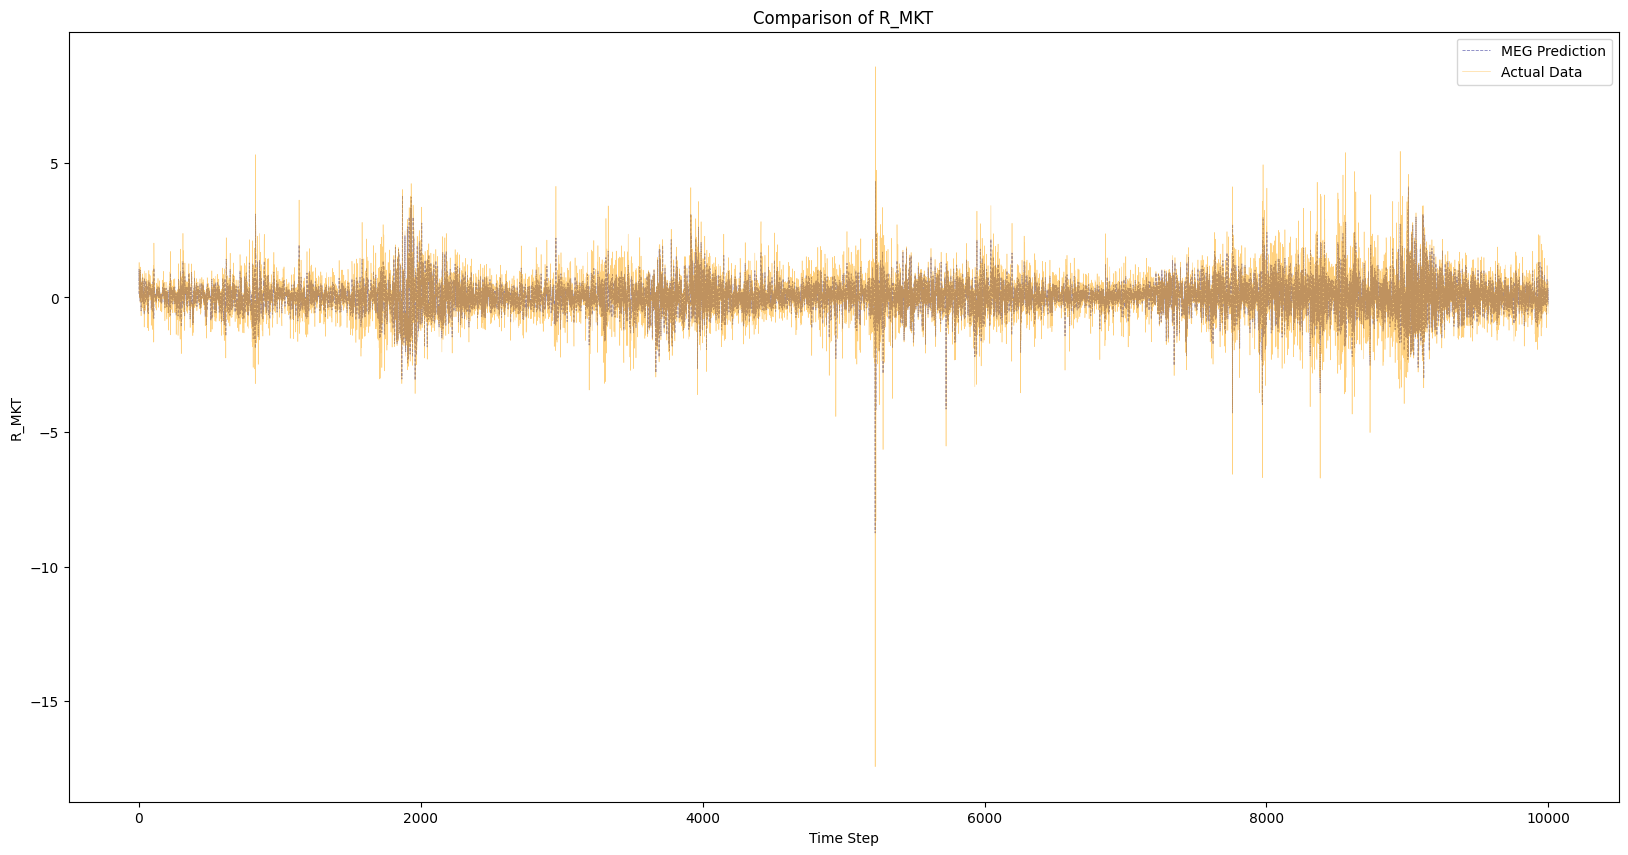

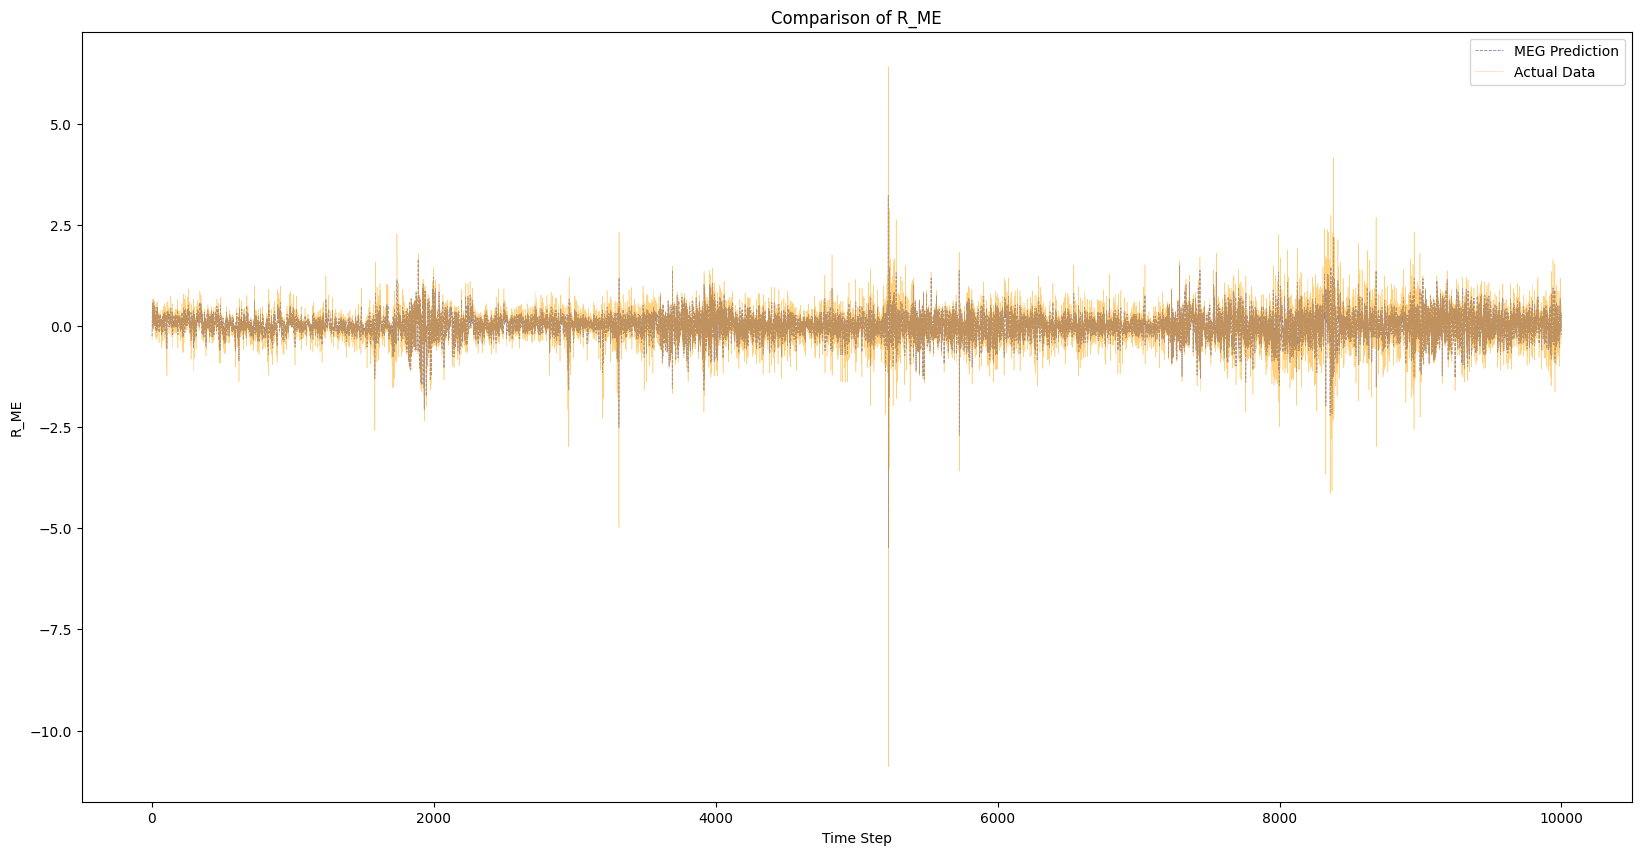

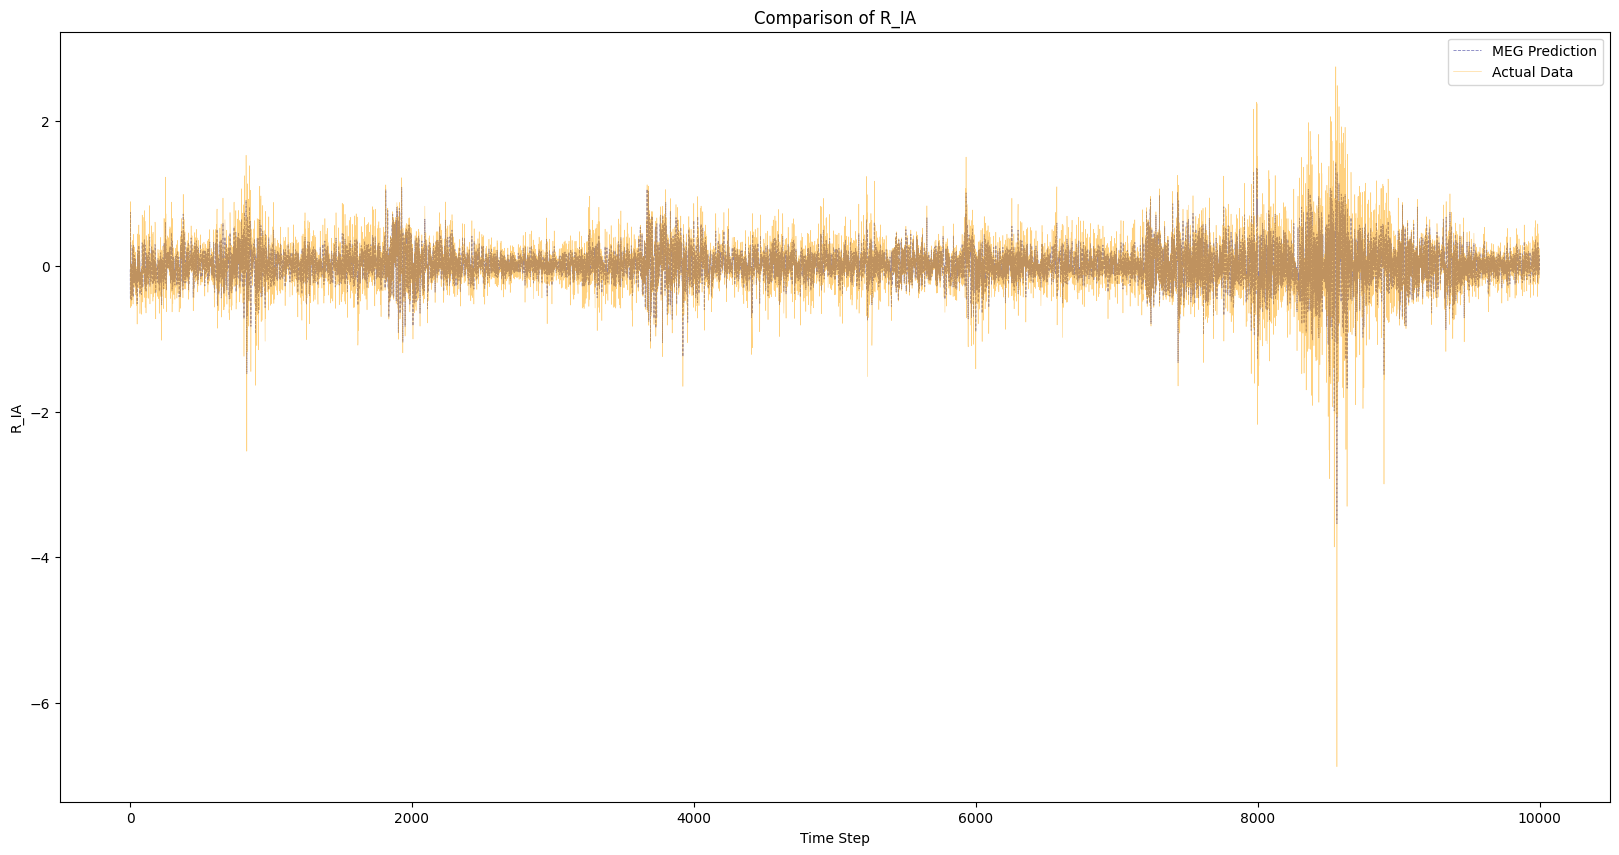

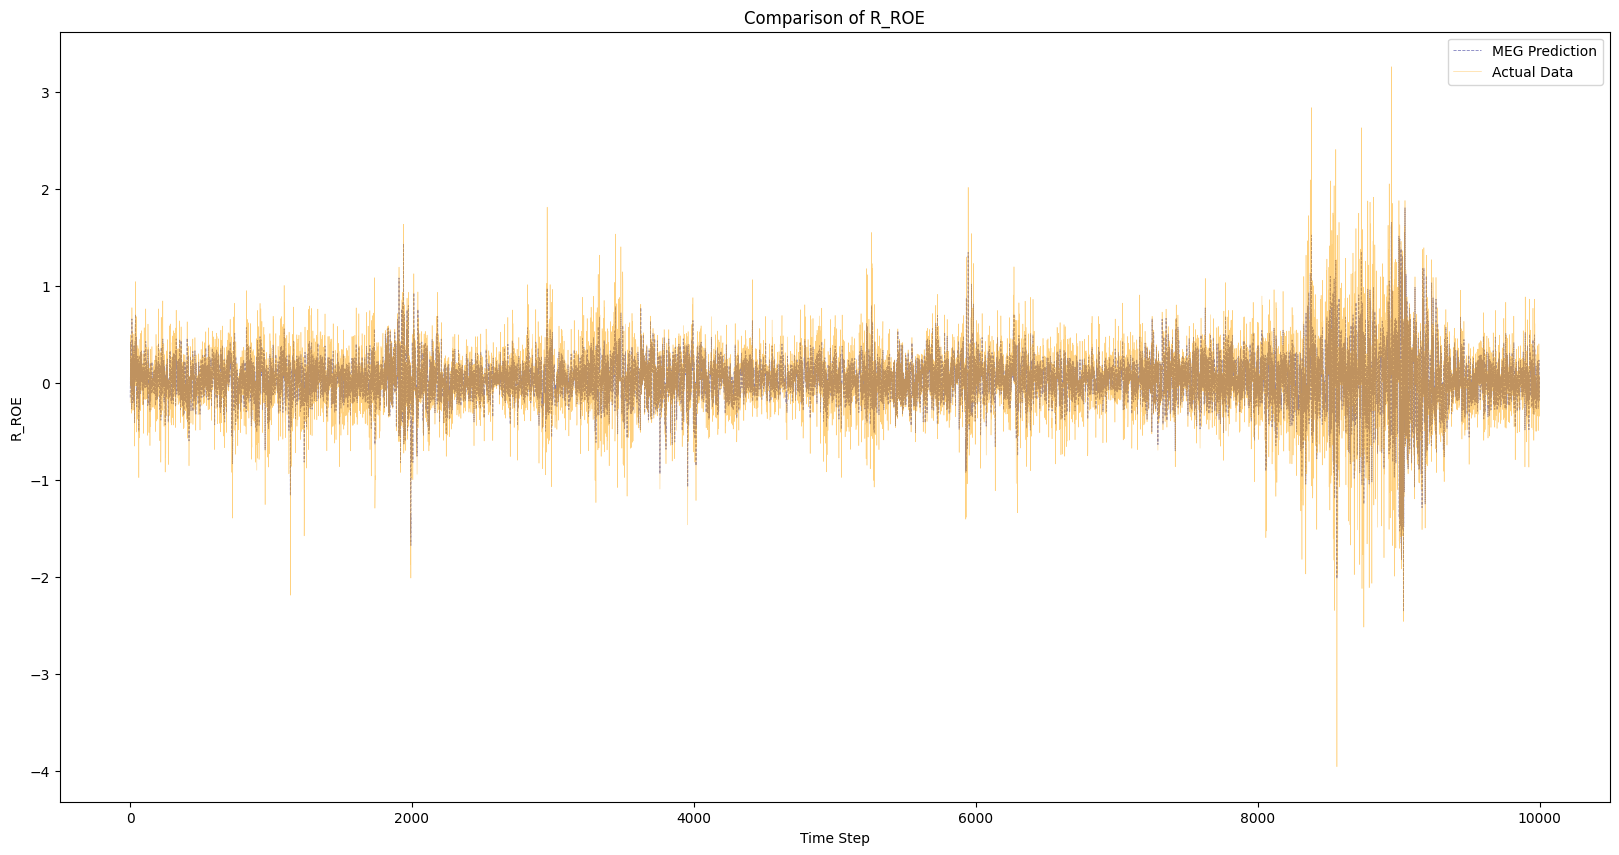

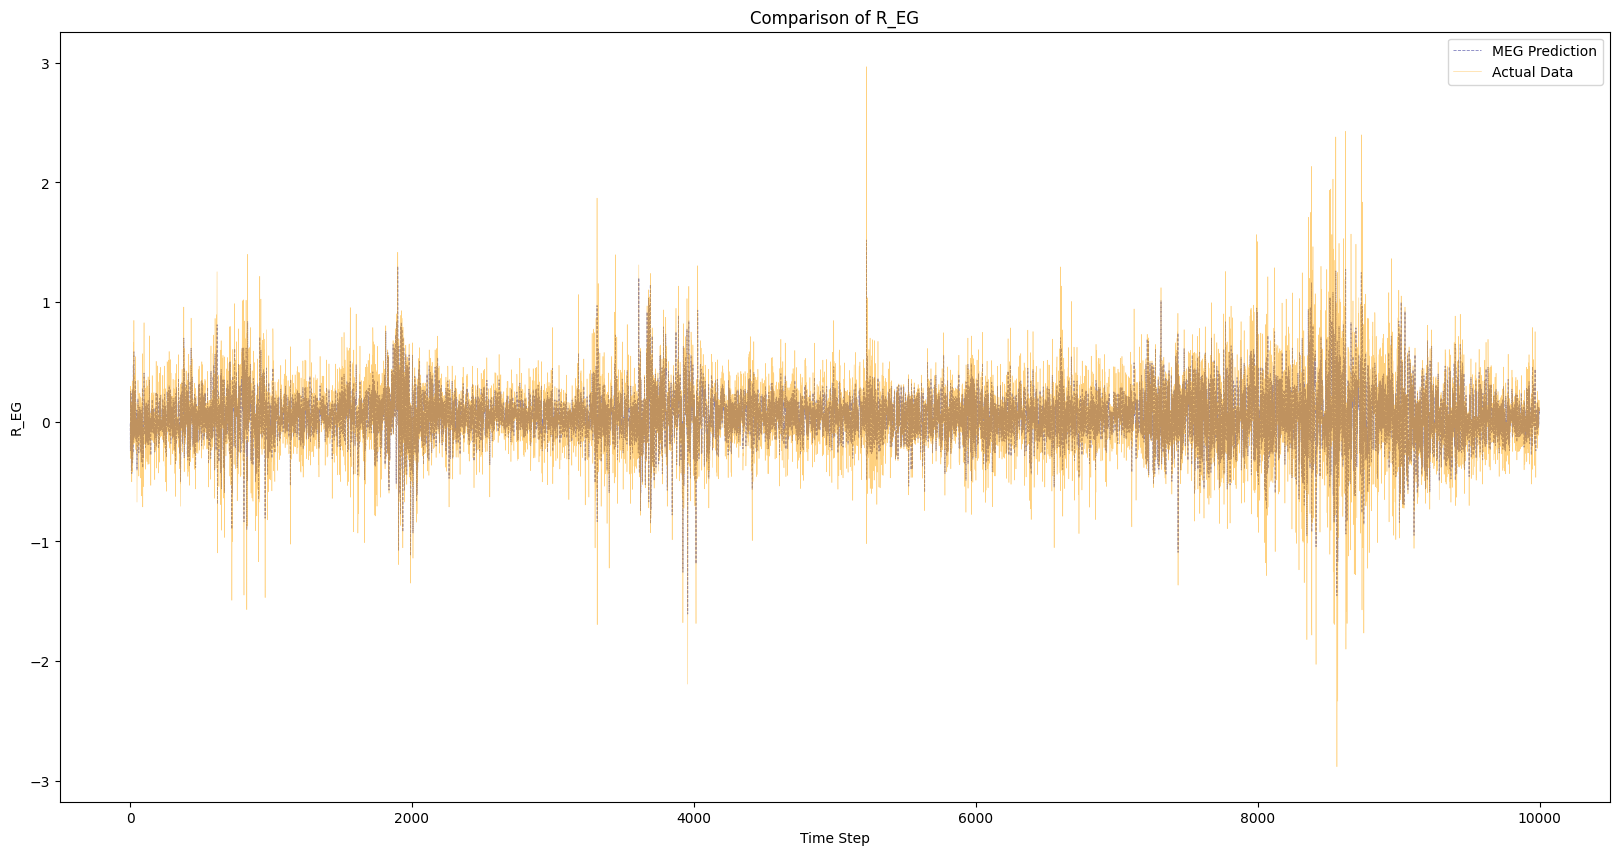

In [ ]:
import matplotlib.pyplot as plt

columns_to_compare = ['R_MKT', 'R_ME', 'R_IA', 'R_ROE', 'R_EG']
for col in columns_to_compare:
    plt.figure(figsize=(20, 10))
    plt.plot(df_marg[col][1:9999], label='MEG Prediction', color='navy', linestyle='--', alpha=0.5, linewidth=0.6)
    plt.plot(df_actual[col][1:9999], label='Actual Data', color='orange', linestyle='-', alpha=0.5, linewidth=0.4)
    plt.title(f'Comparison of {col}')
    plt.xlabel('Time Step')
    plt.ylabel(col)
    plt.legend()
    plt.savefig(f'{col}_comparison_plot.png')
    plt.show()
    plt.close()

In [ ]:
from google.colab import files
for col in columns_to_compare:
    files.download(f'{col}_comparison_plot.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>